<h1><center> Reflectometry Data Analysis and Simulation Software </center></h1>
 <h2><center> - Simulation of a Lipid Bilayer in BornAgain - </center></h2>
<center>[The model simulated in this notebook is based on the Refnx paper] </center>

![title](LipidBilayer.png)

Biologically relevant lipid membrane mimics are modelled by the **Lipid Leaflet model**. The Lipid Leaflet model consists of a **head group** and a **tail group**, each having different properties --SLD, thickness, etc. 

Two lipid leaflets bound together form a "sandwich" called a **Lipid Bilayer**. In this notebook, BornAgain is used to model a Lipid Bilayer adsorbed on Silicon Dioxide (${\rm SiO_2}$) on top of a Silicon substrate. Three different solvents are going to be used: water (${\rm H_2O}$), heavy water (${\rm D_2O}$) and a *contrast-match* mix of the two (${\rm HD_{mix}}$).

---

*Refnx paper: http://scripts.iucr.org/cgi-bin/paper?rg5158*   
*Bornagain: http://www.bornagainproject.org*  

In [1]:
import numpy as np
import bornagain as ba
from bornagain import deg, angstrom
from matplotlib import pyplot as plt
from datetime import datetime as dtime
%matplotlib inline
WAVELENGTH = 1.0 # Dummy wavelength.

The relevant physical parameters are:

 - The SLDs of the materials: $\rho_{\rm i}$
 - The thicknesses of the layers: $T_{\rm i}$
 - The roughnesses of the interfaces between layers: $\sigma_{\rm i}$
 - The solvent-volume-fractions of each layer: $q_{\rm i}$

$i$ stands for each of: 
 - solvent (may be water, heavy water or a mix of both)
 - floating head group
 - floating tail group
 - adsorbed head group 
 - adsorbed tail group 
 - silicon dioxide
 - silicon

The following `class` definition may seen an over-complication for the time being, but it will turn useful later for changing the solvent.

In [2]:
class SampleParameters():
    """
    Class whose only scope is to store and return values for the different
    parameters of the simulation. The defaults are set to the ones found
    by fits produced using Refnx.
    The Refnx fit curve was generated using a Jupyter notebook downloaded from
    http://scripts.iucr.org/cgi-bin/paper?rg5158
    """

    # Scattering length densities:
    _solvent_sld =  6.18989e-06
    _head_f_sld  =  1.88401254e-06
    _tail_f_sld  = -0.37340153e-06
    _head_a_sld  =  1.88401254e-06
    _tail_a_sld  = -0.37340153e-06
    _sio2_sld    =  3.47e-06
    _silicon_sld =  2.07e-06

    #Thicknesses:
    _head_f_thickness =  5.64468
    _head_a_thickness =  9.86971
    _tail_f_thickness = 13.7233
    _tail_a_thickness = 13.7233
    _sio2_thickness   = 12.0885

    # Solvent volume fractions.
    _head_f_sfv = 0.9915395153082305
    _tail_f_sfv = 0.9997855735077633
    _head_a_sfv = 0.5670808231721158
    _tail_a_sfv = 0.9997855735077633
    _sio2_sfv = 1.0 - 0.127675

    # Roughnesses:
    _sio2_rough = 4.80879
    _head_a_rough = 3.00
    _tail_a_rough = 3.00
    _tail_f_rough = 0.00
    _head_f_rough = 3.00
    _solvent_rough = 1.64969


    def __init__(self,params={}):
        assert isinstance(params, dict), "SampleParameters class must be initialized by an instance of dict"
        
        self.solvent_sld = params["solvent_sld"] if "solvent_sld" in params else self._solvent_sld
        self.head_f_sld  = params["head_f_sld"]  if "head_f_sld"  in params else self._head_f_sld
        self.tail_f_sld  = params["tail_f_sld"]  if "tail_f_sld"  in params else self._tail_f_sld
        self.tail_a_sld  = params["tail_a_sld"]  if "tail_a_sld"  in params else self._tail_a_sld
        self.head_a_sld  = params["head_a_sld"]  if "head_a_sld"  in params else self._head_a_sld
        self.sio2_sld    = params["sio2_sld"]    if "sio2_sld"    in params else self._sio2_sld
        self.silicon_sld = params["silicon_sld"] if "silicon_sld" in params else self._silicon_sld

        self.sio2_thickness   = params["sio2_thickness"]   if "sio2_thickness"   in params else self._sio2_thickness
        self.head_a_thickness = params["head_a_thickness"] if "head_a_thickness" in params else self._head_a_thickness
        self.tail_a_thickness = params["tail_a_thickness"] if "tail_a_thickness" in params else self._tail_a_thickness
        self.tail_f_thickness = params["tail_f_thickness"] if "tail_f_thickness" in params else self._tail_f_thickness
        self.head_f_thickness = params["head_f_thickness"] if "head_f_thickness" in params else self._head_f_thickness

        self.sio2_rough = params["sio2_rough"] if "sio2_rough" in params else self._sio2_rough
        self.head_a_rough = params["head_a_rough"] if "head_a_rough" in params else self._head_a_rough
        self.tail_a_rough = params["tail_a_rough"] if "tail_a_rough" in params else self._tail_a_rough
        self.tail_f_rough = params["tail_f_rough"] if "tail_f_rough" in params else self._tail_f_rough
        self.head_f_rough = params["head_f_rough"] if "head_f_rough" in params else self._head_f_rough
        self.solvent_rough = params["solvent_rough"] if "solvent_rough" in params else self._solvent_rough

        self.head_f_sfv  = params["head_f_sfv"]  if "head_f_sfv"  in params else self._head_f_sfv
        self.tail_f_sfv  = params["tail_f_sfv"]  if "tail_f_sfv"  in params else self._tail_f_sfv
        self.tail_a_sfv  = params["tail_a_sfv"]  if "tail_a_sfv"  in params else self._tail_a_sfv
        self.head_a_sfv  = params["head_a_sfv"]  if "head_a_sfv"  in params else self._head_a_sfv
        self.sio2_sfv    = params["sio2_sfv"]    if "sio2_sfv"    in params else self._sio2_sfv

###### Functions for data input. 

N.B. *Real* data is **not** going to be imported. The following functions are used in this notebook to import reflectometry data *modelled* by *Refnx*, which is used as a benchmark in this notebook.

In [3]:
def get_real_data(filename):
    """
    - Get a numpy array from the data file.
    - Translate the coordinate from qvector to incident angle.
    - Normalize intensity values.
    """
    real_data = np.loadtxt(filename, usecols=(0, 1))
    q = real_data[:, 0]
    real_data[:, 0] =  np.arcsin(WAVELENGTH * q /(4.0*np.pi))
    real_data[:, 1] /= real_data[0, 1]
    return real_data


def get_real_data_axis(filename):
    """
    Get axis coordinates of the experimental data
    :return: 1D array with axis coordinates
    """
    return get_real_data(filename)[:, 0]


def get_real_data_values(filename):
    """
    Get experimental data values as a 1D array
    :return: 1D array with experimental data values
    """
    return get_real_data(filename)[:, 1]

## Solvation

The net effect of the solvent is to modify the SLD of each material of the sample:

$$
{\rho}_{\rm i, wet} = q_{\rm i} \, {\rho}_{\rm i} + (1 - q_{\rm i}) \, {\rho}_{\rm solv}.
$$

In this equation, ${\rho}_{\rm i, wet}$ is the overall SLD of material $i$ modified by the presence of a solvent with SLD $\rho_{\rm solv}$. The next code cell defines the function `sld_with_solvent`, which is used to take into account this effect.

In [4]:
def sld_with_solvent(original_sld, solvent_sld, solvent_fraction):
    """
    :param original_sld: sld of the original material
    :param solvent_sld: sld of the solvent material
    :param solvent_fraction: fraction volume of solvent
    :return: overall sld of solvent + original material
    """
    if solvent_fraction < 0 or solvent_fraction > 1:
        print("original sld: {}".format(original_sld))
        print("solvent sld: {}".format(solvent_sld))
        print("solvent_fraction: {}".format(solvent_fraction))
        raise ValueError("Non physical solvent fraction found : {}"
                .format(solvent_fraction))

    osld = original_sld
    ssld = solvent_sld
    sf = solvent_fraction
    rsld = osld * sf + (1.0 - sf) * ssld
    return rsld

The function `get_sample` below uses the above defined class `SampleParameters` to build a sample. That class stores `float64` values that will be passed to the relevant `BornAgain` functions that carry out the actual sample-building.

In BornAgain, each sample layer is constructed as a `ba.Layer`, characterized by a `ba.MaterialBySLD` and a thickness value. All the layers are then stacked together to form a `ba.MultiLayer`, and to each layer interface may be associated a `ba.LayerRoughness`.

In [5]:
def get_sample(xpar, do_solvation = True):
    """
    Define the multilayer sample, using the sample parameters given.
    :param xpar: instance of SampleParameters, relevant parameters for the simulation.
    :return: instance of the generated Multilayer.
    """
    assert isinstance(xpar, SampleParameters), "argument of get_sample must be an instance of SampleParameters"
    if do_solvation:
        head_f_sld = sld_with_solvent(xpar.head_f_sld, xpar.solvent_sld, xpar.head_f_sfv)
        tail_f_sld = sld_with_solvent(xpar.tail_f_sld, xpar.solvent_sld, xpar.tail_f_sfv)
        tail_a_sld = sld_with_solvent(xpar.tail_a_sld, xpar.solvent_sld, xpar.tail_a_sfv)
        head_a_sld = sld_with_solvent(xpar.head_a_sld, xpar.solvent_sld, xpar.head_a_sfv)
        sio2_sld   = sld_with_solvent(xpar.sio2_sld, xpar.solvent_sld, xpar.sio2_sfv)
    else:
        head_f_sld = xpar.head_f_sld
        tail_f_sld = xpar.tail_f_sld
        tail_a_sld = xpar.tail_a_sld
        head_a_sld = xpar.head_a_sld
        sio2_sld   = xpar.sio2_sld
        
    # materials by SLD
    m_solvent = ba.MaterialBySLD("solvent", xpar.solvent_sld, 0.0)
    m_head_f  = ba.MaterialBySLD("head_f", head_f_sld,  0.0)
    m_tail_f  = ba.MaterialBySLD("tail_f", tail_f_sld,  0.0)
    m_tail_a  = ba.MaterialBySLD("tail_a", tail_a_sld,  0.0)
    m_head_a  = ba.MaterialBySLD("head_a", head_a_sld,  0.0)
    m_sio2    = ba.MaterialBySLD("sio2", sio2_sld,  0.0)
    m_silicon = ba.MaterialBySLD("silicon", xpar.silicon_sld, 0.0)

    # Layers with some thickness
    silicon_layer = ba.Layer(m_silicon)
    sio2_layer    = ba.Layer(m_sio2,   xpar.sio2_thickness   * angstrom)
    head_a_layer  = ba.Layer(m_head_a, xpar.head_a_thickness * angstrom)
    tail_a_layer  = ba.Layer(m_tail_a, xpar.tail_a_thickness * angstrom)
    tail_f_layer  = ba.Layer(m_tail_f, xpar.tail_f_thickness * angstrom)
    head_f_layer  = ba.Layer(m_head_f, xpar.head_f_thickness * angstrom)
    solvent_layer = ba.Layer(m_solvent)

    # Interlayer roughness
    roughness_Silicon_sio2  = ba.LayerRoughness(xpar.sio2_rough * angstrom,0.0,0.0)
    roughness_sio2_HeadA    = ba.LayerRoughness(xpar.head_a_rough * angstrom,0.0,0.0)
    roughness_HeadA_TailA   = ba.LayerRoughness(xpar.tail_a_rough * angstrom,0.0,0.0)
    roughness_TailA_TailF   = ba.LayerRoughness(xpar.tail_f_rough * angstrom,0.0,0.0)
    roughness_TailF_HeadF   = ba.LayerRoughness(xpar.head_f_rough * angstrom,0.0,0.0)
    roughness_HeadF_solvent = ba.LayerRoughness(xpar.solvent_rough * angstrom,0.0,0.0)

    #Define multilayer
    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(silicon_layer)
    multi_layer.addLayerWithTopRoughness(sio2_layer,    roughness_Silicon_sio2)
    multi_layer.addLayerWithTopRoughness(head_a_layer,  roughness_sio2_HeadA)
    multi_layer.addLayerWithTopRoughness(tail_a_layer,  roughness_HeadA_TailA)
    multi_layer.addLayerWithTopRoughness(tail_f_layer,  roughness_TailA_TailF)
    multi_layer.addLayerWithTopRoughness(head_f_layer,  roughness_TailF_HeadF)
    multi_layer.addLayerWithTopRoughness(solvent_layer, roughness_HeadF_solvent)

    return multi_layer

The function below, `get_simulation`, defines the beam parameters and the kind of experiment (`SpecularSimulation`). The parameters that define the beam are, among others:

 - Beam wavelength spread, $\lambda$, $\delta \lambda$
 - Beam incident angle spread (divergence), $\delta \theta$
 - Beam footprint
 - The wavelength of the beam, $\lambda$ (a fixed dummy parameter in this particular case)
 - The angle $\theta$ range --sampling variable range, taken directly from the data file
 
 ---
 More information about beam footprint and divergence can be found in the BornAgain tutorials:  
 https://www.bornagainproject.org/documentation/sample-models/reflectometry/footprint-correction/  
 https://www.bornagainproject.org/documentation/sample-models/reflectometry/beam-divergence/  

In [6]:
def get_simulation(filename, dlambda = 0.0, dtheta = 0.0, footprint = 0.0):
    """
    - Defines the instrument and the beam.
    - Define the sample.
    - :return:  SpecularSimulation
    """
    wavelength = WAVELENGTH * ba.angstrom
    theta_range = get_real_data_axis(filename)
    d_wl = dlambda * wavelength
    d_ang = dtheta * ba.deg
    n_sig = 3
    n_points = 25
    simulation = ba.SpecularSimulation()
    
    # Add footprint
    simulation.setBeamParameters(wavelength, 
                                 theta_range,
                                 ba.FootprintFactorSquare(footprint)
                                )
    
    # Add beam divergence

    simulation.addParameterDistribution("*/Beam/Wavelength",
                                        ba.DistributionGaussian(wavelength, d_wl),
                                        n_points, n_sig)
    
    simulation.addParameterDistribution("*/Beam/InclinationAngle",
                                        ba.DistributionGaussian(0.0, d_ang),
                                        n_points, n_sig)
    
    return simulation

The following cell defines auxiliary functions to save and show the results of the simulation: 

In [7]:
def save_text_file(data,filename):
    intensity = data.getArray()
    x_axis = data.getAxis(0).getBinCenters()
    array_to_export = np.column_stack((x_axis, intensity))
    np.savetxt(filename,array_to_export)
    return

def comparison_plot(datasim, datafile, title):
    """
    Given a fit (through the fit_objective), save a plot
    to visually compare it with the original data.
    The plot will be saved in the directory containing this
    script.
    """
    # Font sizes and line widths
    FigSize = 10
    FontSize = 20
    BorderWidth = 3
    plt.rcParams.update({'font.size': FontSize})
    plt.rcParams.update({'axes.linewidth': BorderWidth})
    plt.figure(figsize=(1.5*FigSize,FigSize))
    plt.tick_params(width=BorderWidth, length=FontSize, which='major')
    plt.tick_params(width=BorderWidth, length=0.3*FontSize, which='minor')
    
    # We don't use get_real_data, as we want to compare
    # the results to the original data, which is in q space.
    qdata = np.loadtxt(datafile)[:,0]
    idata = np.loadtxt(datafile)[:,1]
    error = np.loadtxt(datafile)[:,2]

    Xdata = qdata
    Ydata = idata

    xbins = np.array(datasim.getAxis(0).getBinCenters())
    Xsimu = 4.0*np.pi*np.sin(xbins*np.pi/180.0)/WAVELENGTH
    Ysimu = datasim.getArray()
    
    rel_error = 2.*np.abs(Ydata-Ysimu)/np.abs(Ydata+Ysimu)
    mean_err = rel_error.mean()

    plt.errorbar(Xdata, Ydata, yerr=error, linewidth = 0.2*FontSize, markersize=FontSize, label = "Fit by Refnx")
    plt.errorbar(Xsimu, Ysimu, linewidth = 0.2*FontSize, markersize=FontSize, label = "Simulation by BornAgain")
    
    plt.semilogy(Xsimu, rel_error,'k--', label = "Relative Error", alpha = 0.3)
    plt.axhline(y=mean_err,color='k', label="Mean Relative Error = $" + str(np.round(mean_err,3)) + "$")
    
    plt.yscale('log')
    plt.xlim([0,0.3])
    plt.title(title)
    
    plt.ylabel('Reflectivity')
    plt.xlabel('Q /$\AA^{-1}$')
    plt.legend()

    fig = plt.gcf()
    save_file=title+"_"+str(dtime.now().date())+"_"+str(dtime.now().time())+".png"
    plt.savefig(save_file)
    plt.show()
    

## Using different solvents

In the rest of the notebook, different solvents are used to define and run reflectometry simulations of lipid bilayers.

In [8]:
sld_solvents = {
    'd2o': 6.18989e-06,
    'h2o': -0.56e-06,
    'hdmix': SampleParameters().silicon_sld
}
wavelength_spread = 0.02
beam_divergence = 0.02
simulation_showcase = [
    ('d2o',   0.00, 0.00, False),
    ('h2o',   0.00, 0.00, False),
    ('hdmix', 0.00, 0.00, False),
    
    ('d2o',   wavelength_spread, 0.00, False),
    ('h2o',   wavelength_spread, 0.00, False),
    ('hdmix', wavelength_spread, 0.00, False),
    
    ('d2o',   0.00, beam_divergence, False),
    ('h2o',   0.00, beam_divergence, False),
    ('hdmix', 0.00, beam_divergence, False),
    
    ('d2o', 0.00, 0.00, True),
    ('h2o', 0.00, 0.00, True),
    ('hdmix', 0.00, 0.00, True),
]

In [9]:
simulation_data = {}
for sc in simulation_showcase:
    name = sc[0]
    dlam = sc[1]
    dthe = sc[2]
    dsol = sc[3]
    sld  = sld_solvents[name]
    in_RefnxFitFile = "./FitByRefnx_"+name+".txt"
    sample_parameters = SampleParameters({'solvent_sld': sld})
    sample = get_sample(sample_parameters,do_solvation = dsol)
    simulation = get_simulation(in_RefnxFitFile, dlambda = dlam, dtheta = dthe)
    simulation.setSample(sample)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data[sc] = results.data()

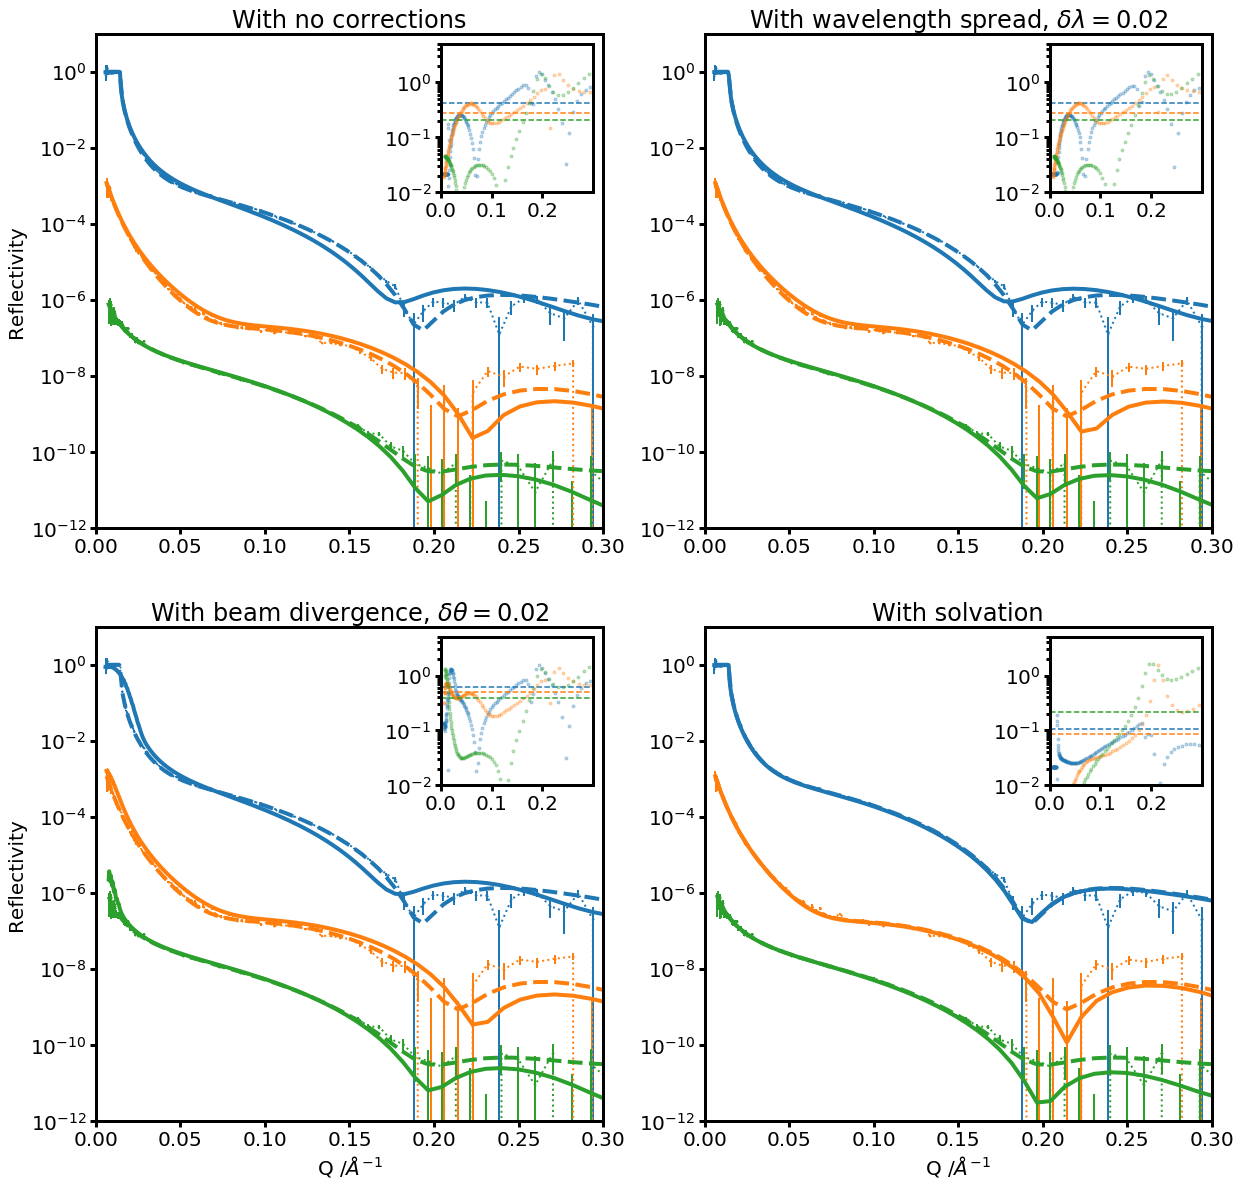

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


FigSize = 20
FontSize = 20
BorderWidth = 3
plt.rcParams.update({'font.size': FontSize})
plt.rcParams.update({'axes.linewidth': BorderWidth})
#plt.figure(figsize=(1.5*FigSize,FigSize))


fig, axs = plt.subplots(2, 2, figsize=(FigSize,FigSize))#,sharex=True,sharey=True)


inset = {}
titles = {(0,0): "With no corrections",
          (0,1): "With wavelength spread, $\delta \lambda = "+str(np.round(wavelength_spread,3))+"$",
          (1,0): "With beam divergence, $\delta \\theta = "+str(np.round(beam_divergence,3))+"$",
          (1,1): "With solvation"
         }
for i, sc in enumerate(simulation_showcase):
    name = sc[0]
    dlam = sc[1]
    dthe = sc[2]
    dsol = sc[3]
    sld  = sld_solvents[name]

    
    # Real data points:
    qdata = np.loadtxt("./RefnxData_"+name+".dat")[:,0]
    idata = np.loadtxt("./RefnxData_"+name+".dat")[:,1]
    erbar = np.loadtxt("./RefnxData_"+name+".dat")[:,2]
    Xdata = qdata
    Ydata = idata
    
    
    # Bornagain simulation:
    datasim = simulation_data[sc]
    xbins = np.array(datasim.getAxis(0).getBinCenters())
    Xsimu = 4.0*np.pi*np.sin(xbins*np.pi/180.0)/WAVELENGTH
    Ysimu = datasim.getArray()
    
    
    # Fit with Refnx model:
    qdata = np.loadtxt("./FitByRefnx_"+name+".txt")[:,0]
    idata = np.loadtxt("./FitByRefnx_"+name+".txt")[:,1]
    erbar = np.loadtxt("./FitByRefnx_"+name+".txt")[:,2]
    Xrfnx = qdata
    Yrfnx = idata
    
    
    #Refnx-Bornagain difference:
    refnx_ba_diff  = 2.*np.abs(Yrfnx-Ysimu)/np.abs(Yrfnx+Ysimu)
    mean_diff = refnx_ba_diff.mean()
    
    
    #CURRENT SUBPLOT:
    I = (i//3)//2
    J = (i//3)%2
    shift = 0.01**(i%3)
    
    #data:
    axs[I,J].tick_params(width=BorderWidth, length=0.3*FontSize, which='major')
    axs[I,J].tick_params(width=BorderWidth, length=0.3*FontSize, which='minor')
    base_line = axs[I,J].errorbar(Xdata, Ydata*shift, yerr=erbar*shift, 
                      linewidth = 0.1*FontSize, 
                      linestyle = ':',
                      marker = '.',
                      markersize=0.1*FontSize, 
                      label = str(sc) + " - Data")
    current_color=base_line.lines[0].get_color()

    #refnx fit:
    axs[I,J].errorbar(Xrfnx, Yrfnx*shift, 
                      color = current_color, 
                      linewidth = 0.2*FontSize,
                      ls = '--',
                      markersize=FontSize, 
                      label = str(sc)+" - Refnx")
    
    #bornagain simulation:
    axs[I,J].errorbar(Xsimu, Ysimu*shift, 
                      color = current_color, 
                      linewidth = 0.2*FontSize,
                      ls = '-',
                      markersize=FontSize, 
                      label = str(sc)+" - BornAgain")

    # CURRENT INSET:
    if not (I,J) in inset.keys():
        inset[(I,J)] = inset_axes(axs[I,J],
                        width="30%",
                        height="30%",
                        )
    current_inset = inset[(I,J)]
    current_inset.semilogy(Xsimu, refnx_ba_diff,'.', color = current_color, label = "Relative Error", alpha = 0.3)
    current_inset.axhline(y=mean_diff,color=current_color,ls='--', label="Mean Relative Error = $" + str(np.round(mean_diff,3)) + "$")
    current_inset.set_ylim([1e-2,5])
    current_inset.set_xlim([0,0.3])
    current_inset.tick_params(width=BorderWidth, length=0.2*FontSize, which='minor')
    current_inset.tick_params(width=BorderWidth, length=0.3*FontSize, which='major')
    current_inset.set_xticks(np.linspace(0,0.2,3),minor=False)
    #current_inset.set_yticks(np.linspace(1e-1,0.2,3),minor=False)
    #current_inset.grid()
    
    
    
    # Scale, titles, limits and labels:
    axs[I,J].set_yscale("log", nonposy='clip')
    axs[I,J].set_xlim([0,0.3])
    axs[I,J].set_ylim([1e-12,1e1])
    axs[I,J].set_title(titles[(I,J)])
    
    if J == 0:
        axs[I,J].set_ylabel('Reflectivity') 
        
    if I == 1:
        axs[I,J].set_xlabel('Q /$\AA^{-1}$')
    #axs[I,J].legend()
    current_plot = (I,J)

fig = plt.gcf()
save_file="Refnx_vs_BornAgain_Lipid_Bilayer_"+str(dtime.now().date())+"_"+str(dtime.now().time())+".png"
plt.savefig(save_file)
plt.show()

Blue Lines: d2o  
Orange Lines: h2o  
Green Lines: hdmix  

Dotted Lines + error bars: data   
Dashed Lines: Refnx  
Continuous Lines: BornAgain  

Inset: relative difference between BornAgain and Refnx
    